<a href="https://colab.research.google.com/github/rahanakunjumuhammed/ev-failure-prediction/blob/main/electric_vehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Import essential libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score

In [9]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Ad/ev_dataset.csv")
df.head()


,voltage,current,temp_battery,soh,vibration,motor_temp,inverter_temp,charging_cycles,odometer_km,ambient_temp,road_condition,failure_type,rul
0,426.657270,104.333104,28.968435,92.430252,6.386574,79.096348,54.108549,1500.000000,116329.906101,24.216194,Smooth,Motor_Bearing_Wear,93
1,408.419042,121.751809,24.210017,94.991475,2.665548,66.275084,52.508595,1439.720819,118758.886746,29.902663,Smooth,Power_Electronics_Failure,113
2,397.531250,108.486566,35.238430,94.904196,2.283813,65.938000,53.891637,1500.000000,91958.605712,20.054336,Smooth,Battery_Cell_Degradation,138
3,370.225190,100.556607,28.104375,94.748835,5.650359,88.911020,54.476935,813.277099,250000.000000,24.653480,Smooth,Motor_Bearing_Wear,103
4,317.974216,123.819394,78.472999,63.319601,7.968332,86.982209,88.811684,1500.000000,132046.499204,23.859387,Smooth,Thermal_System_Failure,35


In [10]:
df.isnull().sum()

,0
voltage,0
current,0
temp_battery,0
soh,0
vibration,0
motor_temp,0
inverter_temp,0
charging_cycles,0
odometer_km,0
ambient_temp,0


In [11]:
# Encode categorical features
le = LabelEncoder()
df["road_condition"] = le.fit_transform(df["road_condition"])
df["failure_type"] = le.fit_transform(df["failure_type"])

In [12]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# === Classification ===
X_class = df.drop(['failure_type', 'rul'], axis=1)
y_class = df['failure_type']

# One-hot encode any remaining non-numeric columns
X_class = pd.get_dummies(X_class)

# Split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Scale
scaler_cls = StandardScaler()
X_train_cls = scaler_cls.fit_transform(X_train_cls)
X_test_cls = scaler_cls.transform(X_test_cls)

# === XGBoost Classifier ===
xgb_clf = XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train_cls, y_train_cls)
y_pred_cls = xgb_clf.predict(X_test_cls)

print("\n🔹 Classification Report (XGBoost Classifier):")
print(classification_report(y_test_cls, y_pred_cls))
print(f"Accuracy: {accuracy_score(y_test_cls, y_pred_cls):.4f}")

# Cross-validation
cv_scores_cls = cross_val_score(xgb_clf, X_train_cls, y_train_cls, cv=5)
print(f"\n🔹 Cross-Validation Accuracy Scores: {cv_scores_cls}")
print(f"🔹 Mean CV Accuracy: {cv_scores_cls.mean():.4f}")

# === Regression (Only for Failures) ===
df["failure_type_label"] = le.inverse_transform(df["failure_type"])
df_failures = df[df["failure_type_label"] != "No_Failure"].drop(columns=["failure_type_label"])

X_reg = df_failures.drop(columns=["failure_type", "rul"])
y_reg = df_failures["rul"]

# One-hot encode categorical variables
X_reg = pd.get_dummies(X_reg)

# Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Scale
scaler_reg = StandardScaler()
X_train_reg = scaler_reg.fit_transform(X_train_reg)
X_test_reg = scaler_reg.transform(X_test_reg)

# === XGBoost Regressor ===
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = xgb_reg.predict(X_test_reg)

print("\n🔹 Regression Evaluation (XGBoost Regressor):")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_reg):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)):.4f}")
print(f"R² Score: {r2_score(y_test_reg, y_pred_reg):.4f}")

# === K-Fold CV for Regression ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse_scores = cross_val_score(xgb_reg, X_train_reg, y_train_reg, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-neg_mse_scores)

print("\n🔹 K-Fold RMSE scores (each fold):", rmse_scores)
print("🔹 Average RMSE:", round(rmse_scores.mean(), 4))

# Cross-validated predictions for regression metrics
y_pred_cv = cross_val_predict(xgb_reg, X_train_reg, y_train_reg, cv=kf)

print("\n🔹 K-Fold Cross-Validation (Manual Evaluation):")
print(f"MAE: {mean_absolute_error(y_train_reg, y_pred_cv):.4f}")
print(f"MSE: {mean_squared_error(y_train_reg, y_pred_cv):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train_reg, y_pred_cv)):.4f}")
print(f"R² Score: {r2_score(y_train_reg, y_pred_cv):.4f}")



🔹 Classification Report (XGBoost Classifier):
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        75
           1       1.00      0.83      0.91        12
           2       1.00      0.96      0.98        45
           3       1.00      1.00      1.00        33
           4       0.92      0.92      0.92        53
           5       1.00      0.93      0.96        28

    accuracy                           0.95       246
   macro avg       0.97      0.94      0.95       246
weighted avg       0.95      0.95      0.95       246

Accuracy: 0.9512

🔹 Cross-Validation Accuracy Scores: [0.97461929 0.94923858 0.97461929 0.96446701 0.94897959]
🔹 Mean CV Accuracy: 0.9624

🔹 Regression Evaluation (XGBoost Regressor):
MAE: 7.1735
RMSE: 11.5844
R² Score: 0.9656

🔹 K-Fold RMSE scores (each fold): [13.90408164 13.23053506 12.32477527 13.35790608 14.72134357]
🔹 Average RMSE: 13.5077

🔹 K-Fold Cross-Validation (Manual Evaluation):
MAE: 8.0788
MS

In [13]:
from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# === SVM Classifier ===
svm_clf = SVC(kernel='rbf', C=0.5)
svm_clf.fit(X_train_cls, y_train_cls)
y_pred_svm = svm_clf.predict(X_test_cls)

print("\n🔹 Classification Report (SVM):")
print(classification_report(y_test_cls, y_pred_svm))
print(f"Accuracy: {accuracy_score(y_test_cls, y_pred_svm):.4f}")

# Cross-validation for classification
cv_scores_svm_cls = cross_val_score(svm_clf, X_train_cls, y_train_cls, cv=5)
print(f"🔹 Cross-Validation Accuracy Scores: {cv_scores_svm_cls}")
print(f"🔹 Mean CV Accuracy: {cv_scores_svm_cls.mean():.4f}")

# === SVR Regressor ===
svr = SVR(kernel='rbf', C=100, epsilon=0.1)
svr.fit(X_train_reg, y_train_reg)
y_pred_svr = svr.predict(X_test_reg)

print("\n🔹 Regression Evaluation (SVR):")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_svr):.4f}")
print(f"MSE: {mean_squared_error(y_test_reg, y_pred_svr):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_svr)):.4f}")
print(f"R² Score: {r2_score(y_test_reg, y_pred_svr):.4f}")

# K-Fold Cross-Validation for SVR
kf = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse_scores = cross_val_score(svr, X_train_reg, y_train_reg, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-neg_mse_scores)

print("\n🔹 K-Fold RMSE scores (each fold):", rmse_scores)
print("🔹 Average RMSE:", round(rmse_scores.mean(), 4))

# Cross-validated predictions and manual metrics
y_pred_cv_svr = cross_val_predict(svr, X_train_reg, y_train_reg, cv=kf)

print("\n🔹 K-Fold Cross-Validation (Manual Evaluation):")
print(f"MAE: {mean_absolute_error(y_train_reg, y_pred_cv_svr):.4f}")
print(f"MSE: {mean_squared_error(y_train_reg, y_pred_cv_svr):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train_reg, y_pred_cv_svr)):.4f}")
print(f"R² Score: {r2_score(y_train_reg, y_pred_cv_svr):.4f}")



🔹 Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        75
           1       0.83      0.42      0.56        12
           2       0.98      1.00      0.99        45
           3       1.00      1.00      1.00        33
           4       0.96      0.89      0.92        53
           5       0.89      0.57      0.70        28

    accuracy                           0.89       246
   macro avg       0.91      0.81      0.84       246
weighted avg       0.90      0.89      0.88       246

Accuracy: 0.8902
🔹 Cross-Validation Accuracy Scores: [0.90862944 0.89340102 0.93908629 0.91370558 0.87244898]
🔹 Mean CV Accuracy: 0.9055

🔹 Regression Evaluation (SVR):
MAE: 8.5539
MSE: 183.1785
RMSE: 13.5343
R² Score: 0.9530

🔹 K-Fold RMSE scores (each fold): [12.98424564 13.37524383 11.03687788 13.89092071 12.4252737 ]
🔹 Average RMSE: 12.7425

🔹 K-Fold Cross-Validation (Manual Evaluation):
MAE: 8.1115
MSE: 163.3396
RMSE

In [14]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# === MLP Classifier ===
mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=1000, random_state=42)
mlp_clf.fit(X_train_cls, y_train_cls)
y_pred_cls = mlp_clf.predict(X_test_cls)

print("\n🔹 Classification Report (MLP Classifier):")
print(classification_report(y_test_cls, y_pred_cls))
print(f"Accuracy: {accuracy_score(y_test_cls, y_pred_cls):.4f}")

# Cross-validation for classification
cv_scores_cls = cross_val_score(mlp_clf, X_train_cls, y_train_cls, cv=5)
print(f"🔹 Cross-Validation Accuracy Scores: {cv_scores_cls}")
print(f"🔹 Mean CV Accuracy: {cv_scores_cls.mean():.4f}")

# === MLP Regressor ===
mlp_reg = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=2000, random_state=42)
mlp_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = mlp_reg.predict(X_test_reg)

print("\n🔹 Regression Evaluation (MLP Regressor):")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_reg):.4f}")
print(f"MSE: {mean_squared_error(y_test_reg, y_pred_reg):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)):.4f}")
print(f"R² Score: {r2_score(y_test_reg, y_pred_reg):.4f}")

# === K-Fold Cross-Validation for Regressor ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse_scores = cross_val_score(mlp_reg, X_train_reg, y_train_reg, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-neg_mse_scores)

print("\n🔹 K-Fold RMSE scores (each fold):", rmse_scores)
print("🔹 Average RMSE:", round(rmse_scores.mean(), 4))

# Cross-validated predictions for manual metric evaluation
y_pred_cv = cross_val_predict(mlp_reg, X_train_reg, y_train_reg, cv=kf)

print("\n🔹 K-Fold Cross-Validation (Manual Evaluation):")
print(f"MAE: {mean_absolute_error(y_train_reg, y_pred_cv):.4f}")
print(f"MSE: {mean_squared_error(y_train_reg, y_pred_cv):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train_reg, y_pred_cv)):.4f}")
print(f"R² Score: {r2_score(y_train_reg, y_pred_cv):.4f}")


🔹 Classification Report (MLP Classifier):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        75
           1       0.91      0.83      0.87        12
           2       0.96      1.00      0.98        45
           3       1.00      1.00      1.00        33
           4       0.91      0.91      0.91        53
           5       1.00      1.00      1.00        28

    accuracy                           0.95       246
   macro avg       0.95      0.95      0.95       246
weighted avg       0.95      0.95      0.95       246

Accuracy: 0.9512
🔹 Cross-Validation Accuracy Scores: [0.97461929 0.94923858 0.96954315 0.96954315 0.9744898 ]
🔹 Mean CV Accuracy: 0.9675

🔹 Regression Evaluation (MLP Regressor):
MAE: 3.7520
MSE: 34.8122
RMSE: 5.9002
R² Score: 0.9911

🔹 K-Fold RMSE scores (each fold): [5.16843296 5.23367267 4.83651998 5.73340511 5.04048393]
🔹 Average RMSE: 5.2025

🔹 K-Fold Cross-Validation (Manual Evaluation):
MAE: 3.4999
MSE: 

In [15]:
import joblib

# After training your classifier and regressor
joblib.dump(mlp_clf, 'mlp_classifier_model.pkl')    # MLP Classifier
joblib.dump(mlp_reg, 'mlp_regressor_model.pkl')     # MLP Regressor

# Also save your scalers and label encoder if used
joblib.dump(scaler_cls, 'scaler_cls.pkl')           # Classifier scaler
joblib.dump(scaler_reg, 'scaler_reg.pkl')           # Regressor scaler
joblib.dump(le, 'label_encoder.pkl')                # Label encoder for failure_type

['label_encoder.pkl']

In [16]:
import numpy as np
import pandas as pd
import joblib

# Load saved models and preprocessing tools
mlp_classifier = joblib.load('mlp_classifier_model.pkl')
mlp_regressor = joblib.load('mlp_regressor_model.pkl')
scaler_cls = joblib.load('scaler_cls.pkl')
scaler_reg = joblib.load('scaler_reg.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# Define input features
feature_names = [
    'voltage', 'current', 'temp_battery', 'soh', 'vibration',
    'motor_temp', 'inverter_temp', 'charging_cycles',
    'odometer_km', 'ambient_temp', 'road_condition'
]

# Take user input
print("Enter the following sensor readings:")
user_input = []
for feature in feature_names:
    value = float(input(f"Enter {feature}: "))
    user_input.append(value)

# ✅ Convert to DataFrame to avoid warning
user_input_array = pd.DataFrame([user_input], columns=feature_names)

# === Predict Failure Type using MLP Classifier ===
user_input_scaled_cls = scaler_cls.transform(user_input_array)
predicted_class_encoded = mlp_classifier.predict(user_input_scaled_cls)[0]
predicted_failure_type = label_encoder.inverse_transform([predicted_class_encoded])[0]

# === Predict RUL using MLP Regressor ===
user_input_scaled_reg = scaler_reg.transform(user_input_array)
predicted_rul = mlp_regressor.predict(user_input_scaled_reg)[0]

# === Show Results ===
print(f"\n🔹 Predicted Failure Type (MLP Classifier): {predicted_failure_type}")

if predicted_failure_type != 'No_Failure':
    print(f"🔹 Predicted RUL (MLP Regressor): {round(predicted_rul, 2)}")
else:
    print("🔹 No failure detected. RUL prediction is not applicable.")

Enter the following sensor readings:
Enter voltage: 401.454306
Enter current: 99.811251
Enter temp_battery: 27.144476
Enter soh: 94.895034
Enter vibration: 1.924249
Enter motor_temp: 63.280206
Enter inverter_temp: 56.047131
Enter charging_cycles: 612.691467
Enter odometer_km: 36959.995521
Enter ambient_temp: 41.979183
Enter road_condition: 2

🔹 Predicted Failure Type (MLP Classifier): No_Failure
🔹 No failure detected. RUL prediction is not applicable.


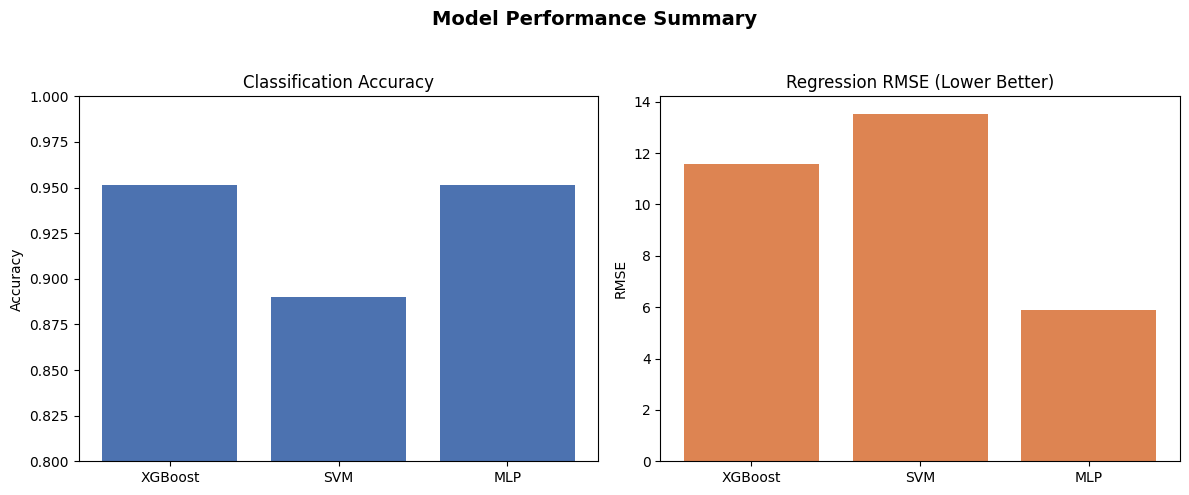

In [17]:
# Simple comparison of classification accuracy and regression RMSE
import matplotlib.pyplot as plt
import numpy as np

models = ["XGBoost", "SVM", "MLP"]

# Classification Accuracy
classification_accuracy = [0.9512, 0.8902, 0.9512]

# Regression RMSE (lower is better)
regression_rmse = [11.5844, 13.5343, 5.9002]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Model Performance Summary", fontsize=14, fontweight='bold')

# Classification Accuracy Plot
axs[0].bar(models, classification_accuracy, color='#4C72B0')
axs[0].set_title("Classification Accuracy")
axs[0].set_ylim([0.8, 1.0])
axs[0].set_ylabel("Accuracy")

# Regression RMSE Plot
axs[1].bar(models, regression_rmse, color='#DD8452')
axs[1].set_title("Regression RMSE (Lower Better)")
axs[1].set_ylabel("RMSE")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()